# Institute for Behavioral Genetics International Statistical Genetics 2023 Workshop 

# Rare Variant Analysis of Sequencing Data with Hail

Learning objectives:

1. Understand statistical models of rare variant effects on phenotype.
2. Understand how to use Hail to perform a Burden test.
3. Understand how to use Hail to perform a SKAT test.

## The Burden Test: Theory

The phrase "genome-wide association study" (GWAS) usually refers to independently testing every variant in a dataset against a phenotype. For a continuous phenotype, we symbolically state that as:

$$
\begin{align*}
N &: \mathbb{N} &\textrm{The number of samples} \\
M &: \mathbb{N} &\textrm{The number of variants} \\
G &: \{0, 1, 2\}^{N \times M} &\textrm{The genotypes represented as the number of alternate alleles} \\
y &: \mathbb{R}^{N} &\textrm{The value of the phenotype for each sample}\\
\beta &: \mathbb{R}^{M} &\textrm{The unknown effect of each variant on the phenotype}\\
\\
\varepsilon_i &\sim \mathcal{N}(0, \sigma^2) &\textrm{Normally distributed measurement error of unknown variance, }\sigma^2\\
y_i &= \beta_j G_{ij} + \varepsilon_i
\end{align*}
$$

This model lacks sufficient statistical power to detect rare variants _because of_ their rarity. There are two ways to address this problem: collect more samples or combine multiple variants into a single association test. In this notebook, we explore two tests that combine multiple variants: the burden test and the squence kernel association test (SKAT).

The burden test considers the sum of effects of a set of variants on a phenotype. When the set of variants is a gene, this test is called a gene burden set. Analagously to testing every variant in GWAS, we typically test many variant-sets. We symbolically state this model as:

$$
\begin{align*}
S_k && \textrm{The } k\textrm{-th set of variants} \\
\\
\varepsilon_i &\sim \mathcal{N}(0, \sigma^2) \\
y_i &= \beta_k \left( \sum_{j \in S_k} G_{ij} \right) + \varepsilon_i
\end{align*}
$$

This model is well-powered for rare variants whose effects have the same direction. For example, if all the variants in a gene increase the chance of disease, a burden test is well-powered. If the direction of effect of variants in the set is random and the effects size are all of similar magnitude, the sum of effects will trend towards zero. We can simulate and visualize this effect:

In [2]:
%config InlineBackend.figure_format = 'retina'

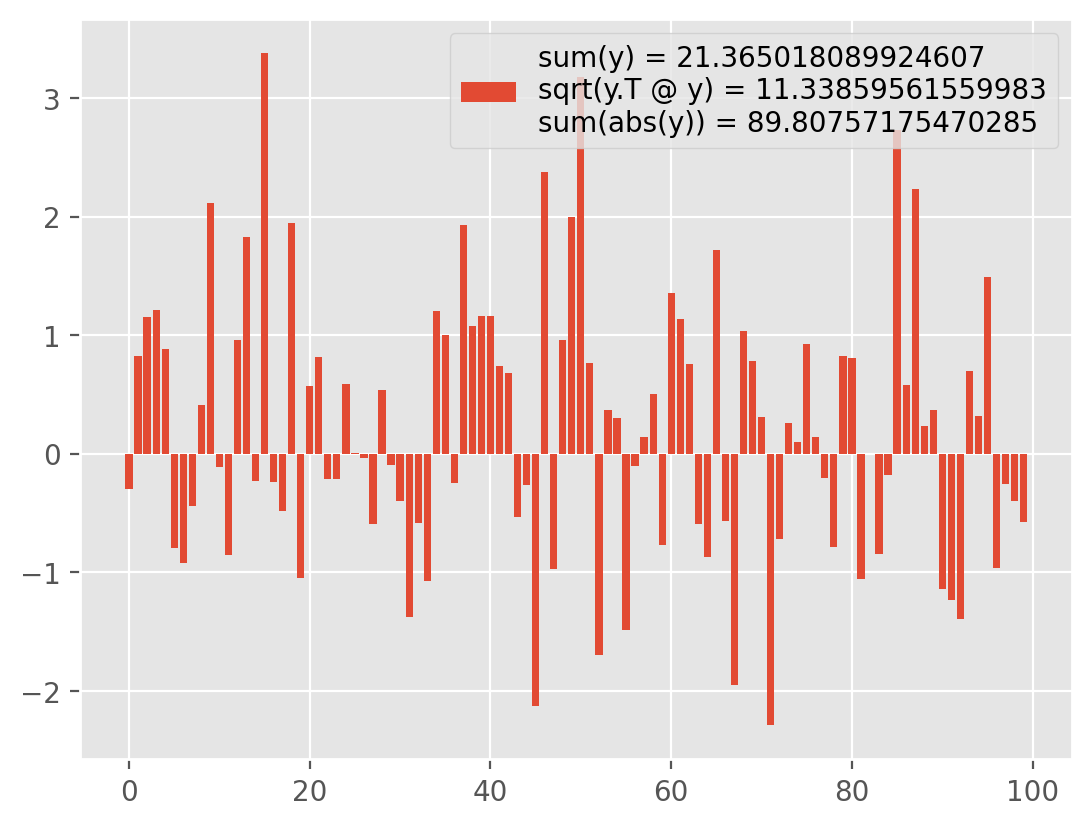

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

effects = np.random.normal(0, 1, size=100)

sum_of_effects = np.sum(effects)
magnitude_of_effects = np.sqrt(effects.T @ effects)
sum_of_abs_of_effects = np.sum(np.abs(effects))

plt.bar(list(range(100)), effects,
        label=(f'sum(y) = {sum_of_effects}\n'
               f'sqrt(y.T @ y) = {magnitude_of_effects}\n'
               f'sum(abs(y)) = {sum_of_abs_of_effects}'))
plt.legend(loc='upper right')
plt.show()

## The Burden Test: Practice
### Setup

Import Hail and configure the plotting system for Notebooks.

In [4]:
import hail as hl

In [5]:
hl.plot.output_notebook()

Loading BokehJS ...

### Step 1: Quality Control & Sample Annotation

The last notebook covered these steps in detail. We'll do them quickly here:

In [6]:
mt = hl.read_matrix_table('resources/hgdp-tgp-rare-variants.mt')

# remove non-PASS variants
mt = mt.filter_rows(hl.len(mt.filters) == 0)

Initializing Hail with default parameters...


23/02/27 16:51:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://wm28c-761:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.109-3cd6e4b2986e
LOGGING: writing to /Users/dking/projects/2021_IBG_Hail/hail-20230227-1651-0.2.109-3cd6e4b2986e.log


#### Remove Common Variants

Next, we will keep variants with an allele frequency of under 1%. Including common variants will only reduce the power of a burden test.

We could rerun `hl.variant_qc` here, or use an aggregator designed to compute allele frequencies and counts:

In [7]:
mt = mt.filter_rows(
    hl.agg.call_stats(mt.GT, mt.alleles).AF[1] < 0.01
)

We also remove variants without any non-reference calls:

In [8]:
mt = mt.filter_rows(
    hl.agg.all(mt.GT.is_hom_ref()),
    keep=False
)

### Step 2: Group by gene

We imported gene names and intervals from GENCODE and created a Hail table keyed by interval. We'll use this table to annotate our genetic data with gene information. After annotation, we can group our variants and perform a linear regression.

In [9]:
genes = hl.read_table('resources/genes.ht')

In [10]:
genes.show()

,
interval,gene_name
interval<locus<GRCh38>>,str
[chr1:11869-chr1:14409],"""DDX11L1"""
[chr1:14404-chr1:29570],"""WASH7P"""
[chr1:17369-chr1:17436],"""MIR6859-1"""
[chr1:29554-chr1:31109],"""MIR1302-2HG"""
[chr1:30366-chr1:30503],"""MIR1302-2"""
[chr1:34554-chr1:36081],"""FAM138A"""
[chr1:52473-chr1:53312],"""OR4G4P"""
[chr1:57598-chr1:64116],"""OR4G11P"""


Recall how we annotated sample phenotypes earlier in the common variant tutorial -- this looks very similar:

In [11]:
mt = mt.annotate_rows(gene_name = genes[mt.locus].gene_name)

In [12]:
phenos = hl.read_table('resources/rare-variant-phenotypes.ht')
mt = mt.annotate_cols(
    pheno1 = phenos[mt.s].pheno1,
    pheno2 = phenos[mt.s].pheno2
)

Let's `show` the resulting annotations on the matrix table to make sure everything worked:

In [13]:
mt.gene_name.show()

,,
locus,alleles,gene_name
locus<GRCh38>,array<str>,str
chr1:949490,"[""G"",""A""]","""NOC2L"""
chr1:950316,"[""G"",""A""]","""NOC2L"""
chr1:950751,"[""C"",""T""]","""NOC2L"""
chr1:951750,"[""G"",""A""]","""NOC2L"""
chr1:952412,"[""C"",""T""]","""NOC2L"""
chr1:953543,"[""G"",""A""]","""NOC2L"""
chr1:953730,"[""G"",""A""]","""NOC2L"""
chr1:954116,"[""C"",""G""]","""NOC2L"""


### Step 3: Aggregate by gene

Hail's modularity makes it easy to perform non-kernel-based burden tests.

We'll compose two general tools:
 - [group_rows_by](https://hail.is/docs/0.2/hail.MatrixTable.html#hail.MatrixTable.group_rows_by) / [aggregate](https://hail.is/docs/0.2/hail.GroupedMatrixTable.html#hail.GroupedMatrixTable.aggregate)
 - [hl.linear_regression_rows](https://hail.is/docs/0.2/methods/stats.html#hail.methods.linear_regression_rows).
 
This means that you can flexibly specify the way genotypes are summarized per gene. Using other tools, you may have a few ways to aggregate, but if you want to do something different you are out of luck!

In [14]:
burden_mt = mt.group_rows_by(mt.gene_name).aggregate(
    n_variants = hl.agg.count_where(mt.GT.n_alt_alleles() > 0)
)

# filter to genes with at least one rare variant!
burden_mt = burden_mt.filter_rows(hl.agg.sum(burden_mt.n_variants) > 0)

Let's explore this new matrix table!

We always start exploring a new matrix table with `describe`. The describe command does not perform any time-consuming or expensive operations. It just introspects on the fields and their "types" (meaning the kind of data, e.g. `float`, `int`, and `str`).

In [15]:
burden_mt.describe(widget=True)

We can also `show` a Matrix Table (or Table). This operation has to actually load and process the data so it might be take some time! We can limit the amount of data processed by specifying `n_cols` and `n_rows`. In the following cell, we look at the top-left, 5x5, corner of the Matrix Table.

In [16]:
burden_mt.show(n_cols=5, n_rows=5)

,,,,,
,'CHMI_CHMI3_WGS2','LP6005441-DNA_F08','HGDP00843','HGDP00392','LP6005441-DNA_H03'
gene_name,n_variants,n_variants,n_variants,n_variants,n_variants
str,int64,int64,int64,int64,int64
"""AC003044.1""",0,0,0,1,0
"""AC005014.1""",0,0,0,0,0
"""AC005599.1""",0,0,0,0,0
"""AC006296.3""",0,0,0,0,0
"""AC007161.3""",0,0,0,0,0


Even this small dataset is too large for us to inspect the value of `n_variants` for every sample at every variant. Instead, we need to use methods to aggregate or summarize data. Hail has some automagical summarization methods such as:

- [`hl.summarize_variants(mt)`](https://hail.is/docs/0.2/methods/genetics.html#hail.methods.summarize_variants)
- [`mt.field.summarize()`](https://hail.is/docs/0.2/hail.expr.Expression.html#hail.expr.Expression.summarize)

If your scientific questions are not answered by those methods, you probably need to use an [aggregator](https://hail.is/docs/0.2/aggregators.html). Aggregators collapse many values into one value. For example, `hl.agg.mean(mt.field)` computes the mean of all the values of `mt.field`. We can calculate the mean depth for each variant:

```
mt = mt.annotate_rows(mean_DP_per_variant = hl.agg.mean(mt.DP))
```

as well as the mean depth for each sample:

```
mt = mt.annotate_cols(mean_DP_per_sample = hl.agg.mean(mt.DP))
```

and the mean depth over all genotypes:

```
mt = mt.annotate_globals(mean_DP_overall = hl.agg.mean(mt.DP))
```

In the next exercise, you will need to use either a summarize function or an aggregator.

#### Exercise

Is this a dense (mostly non-zero) or sparse (mostly zero) matrix? Is this expected? How many variants are in our dataset, and how many genes are there?

In [22]:
xx = burden_mt
xx.aggregate_entries(hl.agg.fraction(xx.n_variants == 0))

0.9676400377719692

In [26]:
xx = burden_mt
xx = xx.annotate_rows(frac_zero = hl.agg.fraction(xx.n_variants == 0))
xx.aggregate_rows(hl.agg.hist(xx.frac_zero, 0, 1, 20))

Struct(bin_edges=[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0], bin_freq=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 4, 12, 16, 152], n_smaller=0, n_larger=0)

In [27]:
xx = burden_mt
xx = xx.annotate_rows(n_zero_variants = hl.agg.count_where(xx.n_variants == 0))
xx.aggregate_rows(hl.agg.counter(xx.n_zero_variants))

{2417: 1,
 2978: 1,
 3235: 1,
 3409: 1,
 3422: 1,
 3428: 1,
 3510: 1,
 3531: 1,
 3533: 1,
 3553: 1,
 3587: 1,
 3596: 1,
 3632: 1,
 3656: 1,
 3662: 1,
 3666: 1,
 3716: 1,
 3718: 1,
 3735: 1,
 3776: 1,
 3778: 1,
 3800: 1,
 3826: 1,
 3848: 1,
 3861: 1,
 3872: 1,
 3878: 1,
 3884: 1,
 3905: 2,
 3915: 1,
 3918: 1,
 3924: 1,
 3925: 2,
 3948: 1,
 3958: 1,
 3960: 1,
 3968: 1,
 3970: 1,
 3976: 2,
 3989: 1,
 3994: 1,
 3998: 1,
 4009: 4,
 4011: 1,
 4014: 1,
 4015: 1,
 4016: 1,
 4021: 2,
 4022: 1,
 4026: 1,
 4029: 1,
 4031: 1,
 4034: 1,
 4039: 1,
 4042: 1,
 4044: 1,
 4050: 2,
 4051: 1,
 4056: 2,
 4057: 1,
 4061: 2,
 4062: 1,
 4065: 1,
 4066: 1,
 4072: 1,
 4073: 1,
 4076: 1,
 4077: 1,
 4078: 2,
 4081: 2,
 4086: 1,
 4087: 2,
 4090: 2,
 4091: 3,
 4092: 1,
 4096: 1,
 4097: 1,
 4100: 2,
 4101: 1,
 4102: 2,
 4105: 2,
 4106: 2,
 4107: 2,
 4110: 1,
 4114: 2,
 4115: 2,
 4116: 1,
 4119: 1,
 4122: 1,
 4123: 1,
 4125: 4,
 4126: 2,
 4128: 1,
 4130: 1,
 4131: 1,
 4132: 2,
 4133: 1,
 4136: 1,
 4137: 1,
 4138: 1,


In [28]:
print('n_variants = ' + str(mt.count_rows()))
print('n_genes = ' + str(burden_mt.count_rows()))

n_variants = 4768


n_genes = 187


In addition to using `annotate_global` to compute dataset-wide aggregations, we can combine row-wise and column-wise aggregations with `hail.ggplot` to produce visualizations. Instead of relying on our brains to make sense of things like mean and variance, we can let our brain consume the entire distribution of the data!

In [29]:
from hail.ggplot import *
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'

xx = burden_mt
xx = xx.annotate_rows(
    n_zero = hl.agg.count_where(xx.n_variants != 0)
)

ggplot(xx) + geom_col(aes(x=xx.gene_name, y=xx.n_zero))

### Step 4: Run linear regression per gene

Hail is designed as a set of resuable modules and functions. In this section, we will re-use several functions from the first notebook but apply them to our =burden_mt= which is keyed by gene instead of locus and contains combined variants rather than genotype calls.

In [30]:
_, pca_scores, _ = hl.hwe_normalized_pca(mt.GT)

In [31]:
burden_mt = burden_mt.annotate_cols(pca = pca_scores[burden_mt.s])

burden_results = hl.linear_regression_rows(
    y=burden_mt.pheno1, 
    x=burden_mt.n_variants,
    covariates=[1.0, 
                burden_mt.pca.scores[0], 
                burden_mt.pca.scores[1], 
                burden_mt.pca.scores[2]])

We use Hail's new plotting system, `hl.ggplot`, to show a bar graph of the burden results. Notice that the genes are sorted alphabetically, not by genomic location!

In [32]:
from hail.ggplot import *
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'

ht = burden_results
ggplot(ht) + geom_col(aes(x=ht.gene_name, y=-hl.log(ht.p_value, base=10)))

We can also look at the first ten results in ascending order of p-value.

In [33]:
burden_results.order_by(burden_results.p_value).show()

,,,,,,,
gene_name,n,sum_x,y_transpose_x,beta,standard_error,t_stat,p_value
str,int32,float64,float64,float64,float64,float64,float64
"""MREG""",4151,2.36e+02,1.26e+03,5.38e+00,1.29e+00,4.17e+00,3.11e-05
"""TFB2M""",4151,1.44e+02,7.31e+02,5.07e+00,1.68e+00,3.03e+00,2.48e-03
"""AC131235.2""",4151,2.00e+00,7.11e+01,3.58e+01,1.42e+01,2.53e+00,1.15e-02
"""EGLN1""",4151,1.56e+02,6.24e+02,4.18e+00,1.66e+00,2.51e+00,1.20e-02
"""TLCD4""",4151,6.00e+01,3.35e+02,5.49e+00,2.57e+00,2.14e+00,3.27e-02
"""LINC02591""",4151,1.00e+00,4.21e+01,4.22e+01,2.00e+01,2.11e+00,3.50e-02
"""NOC2L""",4151,3.60e+01,-2.35e+02,-6.86e+00,3.31e+00,-2.07e+00,3.84e-02
"""LINC01397""",4151,1.43e+02,4.63e+02,3.36e+00,1.72e+00,1.95e+00,5.13e-02


Finally, a Q-Q plot is meaningful on genes. Let's plot one:

In [34]:
p = hl.plot.qq(burden_results.p_value)
hl.plot.show(p)

With fewer tests performed (one per gene, instead of one per variant), the X and Y range of the Q-Q plot is much smaller than in the common variant association practical.

Let's compare the burden test to a standard GWAS. Recall that a standard GWAS performs a large number of tests and therefore must overcome a substantial multiple testing burden. We also look at the genomic locations for some of our top burden genes.

In [35]:
genes.filter(hl.set(['MREG', 'TFB2M']).contains(genes.gene_name)).show()

,
interval,gene_name
interval<locus<GRCh38>>,str
[chr1:246540561-chr1:246566261],"""TFB2M"""
[chr2:215942584-chr2:216034096],"""MREG"""


In [36]:
mt = mt.annotate_cols(pca = pca_scores[mt.s])


linreg_results = hl.linear_regression_rows(
    y=mt.pheno1, 
    x=mt.GT.n_alt_alleles(),
    covariates=[1.0, 
                mt.pca.scores[0], 
                mt.pca.scores[1], 
                mt.pca.scores[2]])
ht = linreg_results
hl.plot.show(hl.plot.manhattan(ht.p_value))
linreg_results.order_by(linreg_results.p_value).show()

,,,,,,,,
locus,alleles,n,sum_x,y_transpose_x,beta,standard_error,t_stat,p_value
locus<GRCh38>,array<str>,int32,float64,float64,float64,float64,float64,float64
chr2:216026821,"[""A"",""G""]",4151,7.00e+01,7.38e+02,1.08e+01,2.41e+00,4.48e+00,7.59e-06
chr1:95163286,"[""C"",""T""]",4151,9.00e+00,2.29e+02,2.56e+01,6.67e+00,3.83e+00,1.29e-04
chr1:61872068,"[""A"",""G""]",4151,2.00e+00,1.01e+02,5.07e+01,1.41e+01,3.59e+00,3.40e-04
chr7:117738954,"[""G"",""A""]",4151,1.00e+00,7.11e+01,7.11e+01,2.00e+01,3.56e+00,3.81e-04
chr6:143088243,"[""G"",""A""]",4151,1.01e+00,7.11e+01,7.11e+01,2.00e+01,3.56e+00,3.82e-04
chr6:143251809,"[""C"",""T""]",4151,1.00e+00,7.05e+01,7.06e+01,2.00e+01,3.53e+00,4.17e-04
chr5:156232994,"[""G"",""A""]",4151,1.00e+00,-6.96e+01,-6.94e+01,2.00e+01,-3.47e+00,5.29e-04
chr5:156431319,"[""A"",""G""]",4151,4.00e+01,4.37e+02,1.07e+01,3.10e+00,3.44e+00,5.87e-04


## The Weighted Burden Test: Theory

If we can confidently predict the directions of effects (while the effect sizes themselves are still unknown), we can encode that knowledge as a "weight". A burden test with weights is known as a weighted burden test. We symbolically represent it as:

$$
\begin{align*}
S_k && \textrm{The } k\textrm{-th set of variants} \\
w &: \mathbb{R}^M &\textrm{The weights for each variant}\\
\\
\varepsilon_i &\sim \mathcal{N}(0, \sigma^2) \\
y_i &= \beta_k \left( \sum_{j \in S_k} w_j G_{ij} \right) + \varepsilon_i
\end{align*}
$$

## The Weighted Burden Test: Practice

An effective choice of weights can increase the power of a burden test. For example, we may weight variants which are predicted to be damaging higher than synonymous variants. The HGDP+1kG subset dataset we have here, `mt`, contains a few different annotations. Your tasks in this section are:

#### Exercise

1. Explore these annotations using `show` and aggregations.
2. Use a numeric annotation as a weight or compute a new numeric annotaiton from a non-numeric annotation (you might need [`hl.case`](https://hail.is/docs/0.2/functions/core.html#hail.expr.functions.case)).
3. Perform a new burden test using `mt.group_rows_by(...).aggregate(...)`, aggregators, `hl.linear_regression_rows`, and your new weight annotation. Do not use `burden_mt` again!

In [37]:
mt.describe(widget=True)

In [38]:
mt.splice_ai.summarize()

Non-missing,2991 (62.73%)
Missing,1777 (37.27%)
Non-missing,2736 (57.38%)
Missing,2032 (42.62%)
Minimum,0.00
Maximum,0.99
Mean,0.00
Std Dev,0.03
Non-missing,2736 (57.38%)
Missing,2032 (42.62%)
Min Size,10


In [39]:
mt.cadd.summarize()

Non-missing,4623 (96.96%)
Missing,145 (3.04%)
Non-missing,4623 (96.96%)
Missing,145 (3.04%)
Minimum,0.00
Maximum,34.00
Mean,3.33
Std Dev,3.89
Non-missing,4623 (96.96%)
Missing,145 (3.04%)
Minimum,-1.56


In [40]:
mt.aggregate_rows(hl.agg.counter(mt.vep.most_severe_consequence))

{'3_prime_UTR_variant': 122,
 '5_prime_UTR_variant': 41,
 'frameshift_variant': 1,
 'inframe_deletion': 1,
 'intron_variant': 4334,
 'missense_variant': 40,
 'non_coding_transcript_exon_variant': 198,
 'splice_acceptor_variant': 1,
 'splice_donor_variant': 1,
 'splice_region_variant': 12,
 'synonymous_variant': 17}

In [49]:
mt = mt.annotate_rows(
    weight1 = (hl.case()
               .when(mt.vep.most_severe_consequence == "synonymous_variant", 2)
               .when(mt.vep.most_severe_consequence == "intron_variant", 3)
               .when(mt.vep.most_severe_consequence == "missense_variant", 5)
               .default(1)),
    weight2 = mt.cadd.phred
)

mt = mt.annotate_cols(pca = pca_scores[mt.s])


xx = mt.group_rows_by(mt.gene_name).aggregate(
    n_variants = hl.agg.count_where(mt.weight2 * mt.GT.n_alt_alleles() > 0)
)
xx = xx.filter_rows(hl.agg.sum(xx.n_variants) > 0)

weighted_burden = hl.linear_regression_rows(
    y=xx.pheno1, 
    x=xx.n_variants,
    covariates=[1.0, 
                xx.pca.scores[0], 
                xx.pca.scores[1], 
                xx.pca.scores[2]])
ht = weighted_burden
ggplot(ht) + geom_col(aes(x=ht.gene_name, y=-hl.log(ht.p_value, base=10)))

In [50]:
ht.order_by(ht.p_value).show()

,,,,,,,
gene_name,n,sum_x,y_transpose_x,beta,standard_error,t_stat,p_value
str,int32,float64,float64,float64,float64,float64,float64
"""MREG""",4151,2.36e+02,1.26e+03,5.38e+00,1.29e+00,4.17e+00,3.11e-05
"""TFB2M""",4151,1.42e+02,6.93e+02,4.95e+00,1.70e+00,2.91e+00,3.59e-03
"""AC131235.2""",4151,2.00e+00,7.11e+01,3.58e+01,1.42e+01,2.53e+00,1.15e-02
"""EGLN1""",4151,1.55e+02,6.13e+02,4.13e+00,1.67e+00,2.47e+00,1.34e-02
"""LINC02591""",4151,1.00e+00,4.21e+01,4.22e+01,2.00e+01,2.11e+00,3.50e-02
"""NOC2L""",4151,3.50e+01,-2.46e+02,-6.77e+00,3.32e+00,-2.04e+00,4.12e-02
"""TLCD4""",4151,5.90e+01,3.06e+02,5.13e+00,2.59e+00,1.98e+00,4.77e-02
"""LINC01397""",4151,1.43e+02,4.63e+02,3.36e+00,1.72e+00,1.95e+00,5.13e-02


## The Sequence Kernel Association Test (SKAT): Theory

If the directions of effects are unpredictably random, then neither a burden test nor a weighted burden test is well-powered. Instead we can test for _excess variance_ of the effect sizes of a set of variants. The sequence kernel association test (SKAT) is one such test. It does not report an effect size because it does not test the strength of the association. Instead, SKAT reports a $p$-value of rejecting its null hypothesis: that the effect of the genotypes on the phenotypes is zero. The SKAT test involves two models, a null model and a full model. Both models include a set of covariates per sample. The full model is:

$$
\begin{align*}
K && \textrm{The number of covariates} \\
X &: \mathbb{R}^{N \times K} &\textrm{The covariates for each sample} \\
\\
\varepsilon_i &\sim \mathcal{N}(0, \sigma^2) \\
y_i &= X \vec{\alpha} + G \vec{\beta} + \varepsilon_i
\end{align*}
$$

The null model considers only the covariates:

$$
\begin{align*}
y_i &= X \vec{\alpha}_{\textrm{null}} + \varepsilon_i
\end{align*}
$$

The null hypothesis supposes that $\beta = 0$. The test of the null hypothesis essentially investigates the likelihood that the residual variance (i.e. $y - X \widehat{\vec{\alpha}_{\textrm{null}}}$) is truly independently, identically, and normally distributed noise. The details of how to test that are somewhat complex and involve a distribution without a closed form. We refer the interested reader to the [SKAT paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3135811/).

## The Sequence Kernel Association Test (SKAT): Practice

The sequence kernel association test is one of Hail's built-in methods. The SKAT also permits a non-negative weight paramter for each variant. The SKAT paper suggests using weights taken from the CDF of a 1,25-Beta distribution evaluated at the allele frequency of the variant.

In [ ]:
skat_mt = mt
skat_mt = skat_mt.annotate_cols(
    pca = pca_scores[skat_mt.s]
)
skat_mt = hl.variant_qc(skat_mt)
skat_mt = skat_mt.annotate_rows(
    weight = hl.dbeta(skat_mt.variant_qc.AF[1], 1, 25)
)

skat_results = hl.skat(
    skat_mt.gene_name,
    skat_mt.weight,
    y = skat_mt.pheno2, 
    x = skat_mt.GT.n_alt_alleles(),
    covariates = [1.0, 
                  skat_mt.pca.scores[0], 
                  skat_mt.pca.scores[1], 
                  skat_mt.pca.scores[2]]
)

In [ ]:
ht.describe()

In [ ]:
ht = skat_results
ht = ht.annotate(
    p_value = hl.if_else(ht.fault == 0, ht.p_value, 1)
)
ggplot(ht) + geom_col(aes(x=ht.id, y=-hl.log(ht.p_value, base=10)))

In [ ]:
skat_results.order_by(skat_results.p_value).show()

Again, let's compare to a standard GWAS on this phenotype.

In [ ]:
genes.filter(hl.set(['KLHL5', 'SFT2D2']).contains(genes.gene_name)).show()

In [ ]:
mt = mt.annotate_cols(pca = pca_scores[mt.s])

linreg_results = hl.linear_regression_rows(
    y=mt.pheno2, 
    x=mt.GT.n_alt_alleles(),
    covariates=[1.0, 
                mt.pca.scores[0], 
                mt.pca.scores[1], 
                mt.pca.scores[2]])
ht = linreg_results
hl.plot.show(hl.plot.manhattan(ht.p_value))
linreg_results.order_by(linreg_results.p_value).show()

## Logistic Phenotypes

For binary phenotypes, for example from a case-control study, [`hl.logistic_regression_rows`](https://hail.is/docs/0.2/methods/stats.html#hail.methods.logistic_regression_rows) and [`hl.skat(..., logistic=True)`](https://hail.is/docs/0.2/methods/genetics.html#hail.methods.skat) can be used instead of their linear analogues. No other changes to the code are necessary.